In [1]:
from itertools import zip_longest

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import NMF
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm
import warnings

# Suppress specific warnings from ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
def create_beat_grid(beats: np.ndarray, tempo: float, sr: int, hop_length: int, duration: float, unit: str = 'time') -> np.ndarray:
    """Generate beat grid within the duration of a song. Returns beat grid in time units"""
    first_beat_time = librosa.frames_to_time(beats[0], sr=sr, hop_length=hop_length)
    seconds_per_beat = 60.0 / tempo
    num_beats_forward = int((duration - first_beat_time) / seconds_per_beat)
    num_beats_backward = int(first_beat_time / seconds_per_beat) + 1
    beat_times_forward = first_beat_time + np.arange(num_beats_forward) * seconds_per_beat
    beat_times_backward = first_beat_time - np.arange(1, num_beats_backward) * seconds_per_beat
    beat_grid = np.concatenate((np.array([0.0]), beat_times_backward[::-1], beat_times_forward))
    if unit == 'frames':
        beat_grid = librosa.time_to_frames(beat_grid, sr=sr, hop_length=hop_length)
    return beat_grid


def find_optimal_n_components(X, random_state=None):
    """
    Find the optimal number of components for NMF by minimizing the reconstruction error with a penalty term.
    Plots the reconstruction error and the score (reconstruction error + penalty) 
    over different values of n_components.
    """
    max_components = 10
    reconstruction_errors = []
    scores = []
    
    # Calculate the penalty weight
    nmf = NMF(n_components=1, random_state=random_state, max_iter=2000, init='nndsvd')
    W = nmf.fit_transform(X)
    H = nmf.components_
    X_approx = W @ H
    reconstruction_error_1 = np.sum((X - X_approx) ** 2)
    penalty_weight = np.abs(reconstruction_error_1 / max_components)
    
    for n_components in range(1, max_components + 1):
        nmf = NMF(n_components=n_components, random_state=random_state, max_iter=2000, init='nndsvd')
        W = nmf.fit_transform(X)
        H = nmf.components_
        X_approx = W @ H
        reconstruction_error = np.sum((X - X_approx) ** 2)
        penalty = n_components * penalty_weight
        score = reconstruction_error + penalty
        reconstruction_errors.append(reconstruction_error)
        scores.append(score)
        
    optimal_n_components = np.argmin(scores) + 1
    
    return optimal_n_components

In [3]:
df = pd.read_csv('../data/clean_labeled.csv')

# Split the song IDs into train/val/test partitions
song_ids = df["SongID"].unique()
train_ids, temp_ids = train_test_split(song_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

# Initialize lists to store optimal n values for each feature
mel_optimal_n_list = []
tempogram_optimal_n_list = []
mfcc_optimal_n_list = []
chromagram_optimal_n_list = []

# Constants
hop_length = 128
sr = 12000

# Combine train and val song IDs
train_val_ids = np.concatenate((train_ids, val_ids))

progress_bar = tqdm(train_val_ids, desc="Processing songs", unit="song", leave=True)
for song_id in progress_bar:
    # Load audio and extract features
    audio_file = f'../data/audio_files/processed/{song_id}.mp3'
    y, _ = librosa.load(audio_file, sr=sr)
    y_harm, y_perc = librosa.effects.hpss(y)
    onset_env = librosa.onset.onset_strength(y=y_perc, sr=sr, hop_length=hop_length)
    duration = librosa.get_duration(y=onset_env, sr=sr)
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr, hop_length=hop_length)
    beat_grid_frames = create_beat_grid(beats, sr=sr, hop_length=hop_length, tempo=tempo, duration=duration, unit='frames')
    beat_grid_times = create_beat_grid(beats, sr=sr, hop_length=hop_length, tempo=tempo, duration=duration, unit='time')

    # Chromagram
    chromagram = librosa.feature.chroma_cqt(y=y_harm, sr=sr, hop_length=hop_length, bins_per_octave=24)
    chromagram = (chromagram - chromagram.min()) / (chromagram.max() - chromagram.min())
    chromagram_sync = librosa.util.sync(chromagram, beat_grid_frames, aggregate=np.mean)
    chromagram_sync = MinMaxScaler().fit_transform(chromagram_sync.T).T
    chromagram_optimal_n = find_optimal_n_components(chromagram_sync.T)
    chromagram_optimal_n_list.append(chromagram_optimal_n)

    # Mel Spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, hop_length=hop_length)
    mel_sync = librosa.util.sync(mel, beat_grid_frames, aggregate=np.mean)
    mel_sync = MinMaxScaler().fit_transform(mel_sync.T).T
    mel_optimal_n = find_optimal_n_components(mel_sync.T)
    mel_optimal_n_list.append(mel_optimal_n)

    # Tempogram
    tempogram = np.clip(librosa.feature.tempogram(onset_envelope=onset_env, sr=sr, hop_length=hop_length), 0, None)
    tempogram_sync = librosa.util.sync(tempogram, beat_grid_frames, aggregate=np.mean)
    tempogram_sync = MinMaxScaler().fit_transform(tempogram_sync.T).T
    tempogram_optimal_n = find_optimal_n_components(tempogram_sync.T)
    tempogram_optimal_n_list.append(tempogram_optimal_n)

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, hop_length=hop_length)
    mfcc_sync = librosa.util.sync(mfccs, beat_grid_frames, aggregate=np.mean)
    mfcc_sync = MinMaxScaler().fit_transform(mfcc_sync.T).T
    mfcc_optimal_n = find_optimal_n_components(mfcc_sync.T)
    mfcc_optimal_n_list.append(mfcc_optimal_n)

Processing songs:   0%|          | 0/282 [00:00<?, ?song/s]

In [ ]:
find_optimal_n_components(mfcc_sync.T, )

Mel Spectrogram: Average Optimal n = 2.72, Median Optimal n = 3.00
Tempogram: Average Optimal n = 3.07, Median Optimal n = 3.00
MFCCs: Average Optimal n = 3.92, Median Optimal n = 4.00


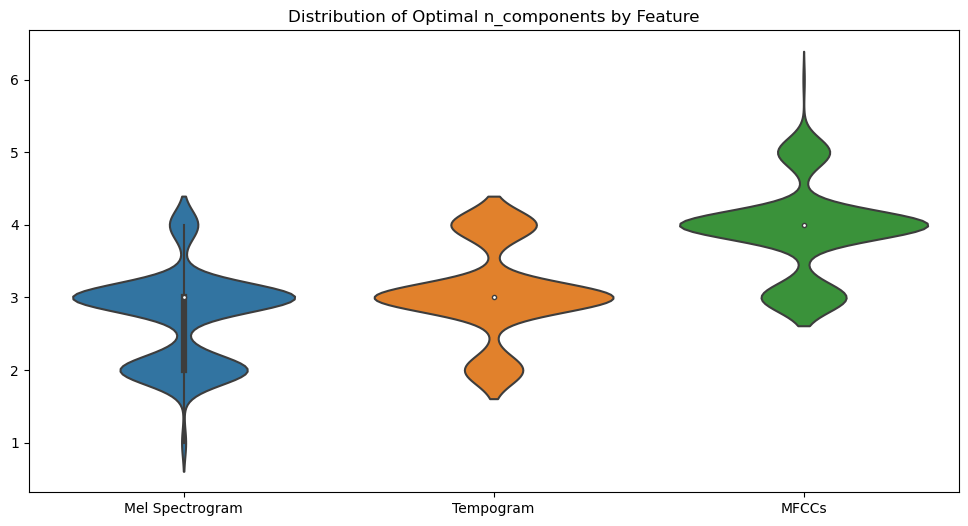

In [5]:
# Create a DataFrame with the optimal n values for each feature and song
data = list(zip_longest(song_ids, mel_optimal_n_list, tempogram_optimal_n_list, mfcc_optimal_n_list))
optimal_n_df = pd.DataFrame(data, columns=['SongID', 'Mel_Optimal_n', 'Tempogram_Optimal_n', 'MFCC_Optimal_n'])

# Drop rows with any missing values (None)
optimal_n_df = optimal_n_df.dropna()

# Calculate average and median optimal n for each feature
avg_mel_optimal_n = optimal_n_df['Mel_Optimal_n'].mean()
median_mel_optimal_n = optimal_n_df['Mel_Optimal_n'].median()

avg_tempogram_optimal_n = optimal_n_df['Tempogram_Optimal_n'].mean()
median_tempogram_optimal_n = optimal_n_df['Tempogram_Optimal_n'].median()

avg_mfcc_optimal_n = optimal_n_df['MFCC_Optimal_n'].mean()
median_mfcc_optimal_n = optimal_n_df['MFCC_Optimal_n'].median()

print(f"Mel Spectrogram: Average Optimal n = {avg_mel_optimal_n:.2f}, Median Optimal n = {median_mel_optimal_n:.2f}")
print(f"Tempogram: Average Optimal n = {avg_tempogram_optimal_n:.2f}, Median Optimal n = {median_tempogram_optimal_n:.2f}")
print(f"MFCCs: Average Optimal n = {avg_mfcc_optimal_n:.2f}, Median Optimal n = {median_mfcc_optimal_n:.2f}")

# Plot the optimal n values for each feature using a violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(data=optimal_n_df[['Mel_Optimal_n', 'Tempogram_Optimal_n', 'MFCC_Optimal_n']])
plt.xticks([0, 1, 2], ['Mel Spectrogram', 'Tempogram', 'MFCCs'])
plt.title('Distribution of Optimal n_components by Feature')
plt.show()

In [2]:
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def detect_key_and_mode(y, sr, hop_length):
    chromagram = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=hop_length, bins_per_octave=24)
    chromagram = (chromagram - chromagram.min()) / (chromagram.max() - chromagram.min())
    chroma_vals = np.sum(chromagram, axis=1)
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    major_profile = np.array([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
    minor_profile = np.array([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17])
    major_profile /= np.linalg.norm(major_profile)
    minor_profile /= np.linalg.norm(minor_profile)
    major_correlations = [np.corrcoef(chroma_vals, np.roll(major_profile, i))[0, 1] for i in range(12)]
    minor_correlations = [np.corrcoef(chroma_vals, np.roll(minor_profile, i))[0, 1] for i in range(12)]
    max_major_idx = np.argmax(major_correlations)
    max_minor_idx = np.argmax(minor_correlations)
    mode = 'major' if major_correlations[max_major_idx] > minor_correlations[max_minor_idx] else 'minor'
    key = note_names[max_major_idx if mode == 'major' else max_minor_idx]
    return key, mode

def count_onsets(onset_env, threshold=0.5):
    """Count the number of onsets in the onset envelope."""
    # Binarize the onset envelope using the threshold
    onset_env_binary = onset_env > threshold

    # Count the number of True values (onsets) in the binary array
    onset_count = np.sum(onset_env_binary)

    return onset_count

def onset_strength_intensity(onset_env):
    """Calculate the intensity of the onset strength envelope."""
    return np.sum(onset_env)

def onset_strength_frequency(onset_env, sr, hop_length):
    """Calculate the frequency of onset strength peaks."""
    # Binarize the onset envelope to get the onset locations
    onset_env_binary = onset_env > 0.5

    # Calculate the time difference between consecutive onsets
    onset_times = np.where(onset_env_binary)[0] * hop_length / sr
    onset_diffs = np.diff(onset_times)

    # Calculate the average time difference (period)
    avg_period = np.mean(onset_diffs)

    # Convert period to frequency
    onset_freq = 1 / avg_period if avg_period > 0 else 0

    return onset_freq

In [5]:
df = pd.read_csv('../data/clean_labeled.csv')
df = df[['SongID', "start_time", "end_time", "label"]]

# Split the song IDs into train/val/test partitions
song_ids = df["SongID"].unique()
train_ids, temp_ids = train_test_split(song_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)
train_val_ids = np.concatenate((train_ids, val_ids))

df = df.loc[df["SongID"].isin(train_val_ids)]

sr = 12000
hop_length = 256
n_fft = 2048

features_list = []

progress_bar = tqdm(df.iterrows(), total=len(df), desc="Processing segments", unit="segment")
for idx, row in progress_bar:
    song_id = row['SongID']
    start_time, end_time = row['start_time'], row['end_time']
    label = row['label']
    if end_time - start_time < 10: 
        continue

    audio_file = f'../data/audio_files/processed/{song_id}.mp3'
    y, _ = librosa.load(audio_file, sr=sr, offset=start_time, duration=end_time - start_time)
    y = np.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)
    n_fft = min(2048, len(y))   
    
    # Mel Spectrogram Features
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hop_length, n_fft=n_fft)
    mel_spec_contrast = np.max(mel_spec, axis=1) - np.min(mel_spec, axis=1)  # Contrast across time and frequency bands
    mel_spec_bands = np.array_split(mel_spec, 4, axis=0)  # Split into 4 frequency bands
    mel_spec_band_means = [np.mean(band, axis=1) for band in mel_spec_bands]  # Mean across time for each band
    mel_spec_band_stds = [np.std(band, axis=1) for band in mel_spec_bands]  # Std across time for each band

    # Onset Envelope and Zero-Crossing Rate
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    onset_count = count_onsets(onset_env)
    onset_intensity = onset_strength_intensity(onset_env)
    onset_frequency = onset_strength_frequency(onset_env, sr, hop_length)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y, hop_length=hop_length)
    zero_crossing_rate_mean = np.mean(zero_crossing_rate)

    # Beat features
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr, hop_length=hop_length)

    # Calculate beat-related features
    beat_times = librosa.frames_to_time(beats, sr=sr, hop_length=hop_length)
    beat_period = np.mean(np.diff(beat_times))
    beat_period_std = np.std(np.diff(beat_times))
    beat_salience = np.mean(onset_env[beats.astype(int)])

    # RMS Energy Features
    rms_energy = librosa.feature.rms(y=y, hop_length=hop_length)
    rms_energy_contrast = np.max(rms_energy) - np.min(rms_energy)
    rms_energy_bands = np.array_split(rms_energy, 4)  # Split into 4 time bands
    rms_energy_band_means = [np.mean(band) for band in rms_energy_bands]  # Mean for each time band

    # Tempogram Features
    tempogram = librosa.feature.tempogram(y=y, sr=sr, hop_length=hop_length)
    tempo_mean = np.mean(tempogram)
    tempo_std = np.std(tempogram)
    prominent_tempo = np.argmax(np.mean(tempogram, axis=1))
    tempo_stability = np.std(np.argmax(tempogram, axis=0))

    # MFCC Features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, hop_length=hop_length)
    mfcc_mean = np.mean(mfcc, axis=1)  # Mean across time
    mfcc_std = np.std(mfcc, axis=1)  # Std across time
    mfcc_delta = librosa.feature.delta(mfcc, axis=-1)  # Compute delta features along the time axis
    mfcc_delta_mean = np.mean(mfcc_delta, axis=0)  # Mean across MFCC coefficients
    mfcc_delta_std = np.std(mfcc_delta, axis=0)  # Std across MFCC coefficients

    # Spectral Features
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, hop_length=hop_length)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=hop_length)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=hop_length, fmin=4)
    spec_centroid_mean = np.mean(spectral_centroid)
    spec_centroid_std = np.std(spectral_centroid)
    spec_bw_mean = np.mean(spectral_bandwidth)
    spec_bw_std = np.std(spectral_bandwidth)
    spec_rolloff_mean = np.mean(spectral_rolloff)
    spec_rolloff_std = np.std(spectral_rolloff)
    spec_contrast_mean = np.mean(spectral_contrast, axis=1)
    spec_contrast_std = np.std(spectral_contrast, axis=1)

    # Chroma-based Features
    chromagram = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=hop_length)
    chroma_mean = np.mean(chromagram, axis=1)
    chroma_std = np.std(chromagram, axis=1)
    chroma_contrast = np.max(chromagram, axis=1) - np.min(chromagram, axis=1)

    key, mode = detect_key_and_mode(y, sr, hop_length)

    duration = librosa.get_duration(y=y, sr=sr)

    features = {
        'song_id': row['SongID'],
        'start_time': start_time,
        'end_time': end_time,
        'label': row['label'],
        'mel_spec_contrast': mel_spec_contrast,
        'mel_spec_band_means': mel_spec_band_means,
        'mel_spec_band_stds': mel_spec_band_stds,
        'onset_count': onset_count,
        'onset_strength_intensity': onset_intensity,
        'onset_strength_frequency': onset_frequency,
        'zero_crossing_rate_mean': zero_crossing_rate_mean,
        'rms_energy_contrast': rms_energy_contrast,
        'rms_energy_band_means': rms_energy_band_means,
        'tempo_mean': tempo_mean,
        'tempo_std': tempo_std,
        'prominent_tempo': prominent_tempo,
        'tempo_stability': tempo_stability,
        'mfcc_mean': mfcc_mean,
        'mfcc_std': mfcc_std,
        'mfcc_delta_mean': mfcc_delta_mean,
        'mfcc_delta_std': mfcc_delta_std,
        'spec_centroid_mean': spec_centroid_mean,
        'spec_centroid_std': spec_centroid_std,
        'spec_bw_mean': spec_bw_mean,
        'spec_bw_std': spec_bw_std,
        'spec_rolloff_mean': spec_rolloff_mean,
        'spec_rolloff_std': spec_rolloff_std,
        'spec_contrast_mean': spec_contrast_mean,
        'spec_contrast_std': spec_contrast_std,
        'chroma_mean': chroma_mean,
        'chroma_std': chroma_std,
        'chroma_contrast': chroma_contrast,
        'tempo': tempo,
        'beat_times': beat_times,
        'beat_period': beat_period,
        'beat_period_std': beat_period_std,
        'beat_salience': beat_salience,
        'key': key,
        'mode': mode,
        'duration': duration
    }

    features_list.append(features)

features_df = pd.DataFrame(features_list)

Processing segments:   0%|          | 0/1549 [00:00<?, ?segment/s]

c:\Users\denni\anaconda3\envs\mixin\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\denni\anaconda3\envs\mixin\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\denni\anaconda3\envs\mixin\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Processing segments: 100%|██████████| 1549/1549 [24:58<00:00,  1.03segment/s]


In [6]:
features_df.to_csv("../data/EDA_features.csv", index=False)

In [ ]:
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import shap

def extract_features(y, sr, hop_length, n_fft):
    # Chromagram
    chromagram = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=hop_length)

    # Tempogram
    tempogram = librosa.feature.tempogram(y=y, sr=sr, hop_length=hop_length)

    # Mel Spectrogram
    melspec = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hop_length, n_fft=n_fft)

    # RMS Energy
    rms_energy = librosa.feature.rms(y=y, hop_length=hop_length)

    # Onset Envelope
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)

    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=20)

    # Spectral Features
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, hop_length=hop_length)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=hop_length)
    spectral_features = np.vstack([spectral_centroid, spectral_bandwidth, spectral_rolloff])

    # Tonnetz
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr, hop_length=hop_length)

    # Zero-Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y=y, hop_length=hop_length)

    return chromagram, tempogram, melspec, rms_energy, onset_env, mfcc, spectral_features, tonnetz, zcr

# Load and preprocess the DataFrame
df = pd.read_csv('../data/clean_labeled.csv')
df = df[['SongID', "start_time", "end_time", "label"]]
song_ids = df["SongID"].unique()
train_ids, temp_ids = train_test_split(song_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)
train_val_ids = np.concatenate((train_ids, val_ids))
df = df.loc[df["SongID"].isin(train_val_ids)]

# Audio processing parameters
sr = 12000
hop_length = 256
n_fft = 2048

features_list = []
progress_bar = tqdm(df.iterrows(), total=len(df), desc="Processing segments", unit="segment")

# Determine the maximum number of time frames/samples across all segments
max_length = 0  # Initialize max_length

for idx, row in progress_bar:
    song_id = row['SongID']
    start_time, end_time = row['start_time'], row['end_time']
    label = row['label']
    if end_time - start_time < 10:
        continue

    audio_file = f'../data/audio_files/processed/{song_id}.mp3'
    y, _ = librosa.load(audio_file, sr=sr, offset=start_time, duration=end_time - start_time)
    chromagram, tempogram, melspec, rms_energy, onset_env, mfcc, spectral_features, tonnetz, zcr = extract_features(y, sr, hop_length, n_fft)

    # Update max_length dynamically
    max_length = max(max_length, chromagram.shape[1], tempogram.shape[1], melspec.shape[1], rms_energy.shape[1], onset_env.shape[1], mfcc.shape[1], spectral_features.shape[1], tonnetz.shape[1], zcr.shape[1])

    # Pad and flatten features
    chromagram = np.pad(chromagram, ((0, 0), (0, max_length - chromagram.shape[1])), mode='constant').flatten()
    tempogram = np.pad(tempogram, ((0, 0), (0, max_length - tempogram.shape[1])), mode='constant').flatten()
    melspec = np.pad(melspec, ((0, 0), (0, max_length - melspec.shape[1])), mode='constant').flatten()
    rms_energy = np.pad(rms_energy, (0, max_length - rms_energy.shape[1]), mode='constant').flatten()
    onset_env = np.pad(onset_env, (0, max_length - onset_env.shape[1]), mode='constant').flatten()
    mfcc = np.pad(mfcc, ((0, 0), (0, max_length - mfcc.shape[1])), mode='constant').flatten()
    spectral_features = np.pad(spectral_features, ((0, 0), (0, max_length - spectral_features.shape[1])), mode='constant').flatten()
    tonnetz = np.pad(tonnetz, ((0, 0), (0, max_length - tonnetz.shape[1])), mode='constant').flatten()
    zcr = np.pad(zcr, (0, max_length - zcr.shape[1]), mode='constant').flatten()

    # Convert chorus labels to 1 and other labels to 0
    numeric_label = 1 if label == 'chorus' else 0

    features = {
        'SongID': song_id,
        'chromagram': chromagram,
        'tempogram': tempogram,
        'melspec': melspec,
        'rms_energy': rms_energy,
        'onset_env': onset_env,
        'mfcc': mfcc,
        'spectral_features': spectral_features,
        'tonnetz': tonnetz,
        'zcr': zcr,
        'label': numeric_label  # Use the numeric label here
    }

    features_list.append(features)

# Convert the list of features into a DataFrame
features_df = pd.DataFrame(features_list)
